## Gaussian Process Regression wit GPy

In [129]:
import pandas as pd

### 1. Read the data

In [130]:
all_positions = pd.read_csv('../data/positions_xyz_2024-02-27_11h29m.csv', delimiter=',')
all_positions

,x,y,z
0,7.140000,3.070000,15.00000
1,10.140000,3.070000,15.00000
2,10.140000,3.070000,15.00000
3,10.140000,3.070000,15.00000
4,10.138330,3.169981,15.09998
...,...,...,...
500,5.179743,0.799010,12.72901
501,5.256516,0.734943,12.66494
502,5.335387,0.673466,12.60347
503,5.416258,0.614656,12.54466


In [131]:
all_red_ball_positions = pd.read_csv('../data/red_ball_coordinates_128px_2024-02-27_11h29m.csv', delimiter=',')
all_red_ball_positions

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6
0,0.400000,41.800000,86.846154,39.269231,NaN,NaN,36.387097,80.064516,85.000000,81.518519,NaN,NaN,68.600,121.600000
1,0.500000,42.500000,86.857143,40.214286,NaN,NaN,38.360000,81.800000,85.285714,82.523810,NaN,NaN,68.500,120.166667
2,0.500000,43.500000,87.000000,41.407407,NaN,NaN,38.043478,82.434783,85.875000,83.541667,NaN,NaN,68.500,120.166667
3,1.000000,44.846154,87.291667,41.833333,NaN,NaN,37.636364,82.954545,85.681818,84.227273,NaN,NaN,68.500,120.166667
4,1.166667,45.444444,87.476190,43.238095,NaN,NaN,38.680000,83.920000,86.440000,85.080000,NaN,NaN,68.500,120.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,67.750000,10.500000,57.555556,35.000000,63.880952,59.071429,93.311475,60.836066,59.750000,69.250000,54.480769,104.576923,68.375,119.125000
497,66.957447,8.957447,57.555556,35.000000,63.200000,57.700000,89.754386,60.315789,59.750000,69.250000,53.672727,103.509091,68.375,119.125000
498,65.697674,10.186047,57.555556,35.000000,62.487805,57.048780,91.633333,59.216667,59.750000,69.250000,53.260000,102.500000,68.375,119.125000
499,64.770833,5.062500,57.555556,35.000000,61.000000,54.769231,89.706897,57.603448,59.750000,69.250000,51.529412,100.882353,68.375,119.125000


In [132]:
all_positions = all_positions.iloc[4:]
all_red_ball_positions.shape,  all_positions.shape

((501, 14), (501, 3))

### 2. Handle Missing Values

In [133]:
from sklearn.impute import SimpleImputer, KNNImputer

imputer_mean = SimpleImputer(strategy='mean')
imputer_knn = KNNImputer(n_neighbors=2)
X_all = imputer_mean.fit_transform(all_red_ball_positions)
y_all = imputer_mean.fit_transform(all_positions)
X_all.shape, y_all.shape

((501, 14), (501, 3))

### 3. Prepare the Data

In [134]:
total_samples = len(X_all)
train_samples = int(0.8 * total_samples)

# Split the data
X_train = X_all[:train_samples]
y_train = y_all[:train_samples]

X_test = X_all[train_samples:]
y_test = y_all[train_samples:]

In [135]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 14), (101, 14), (400, 3), (101, 3))

In [136]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled_train = scaler_x.fit_transform(X_train)
y_scaled_train = scaler_y.fit_transform(y_train)

### 4. Train the Model

In [137]:
from GPy.kern import RBF
from GPy.models import GPRegression

#### 4.1 Train GP Regression Model with GPy
For normal regression tasks

In [138]:
kernel = RBF(input_dim=14)
model = GPRegression(X_scaled_train, y_scaled_train, kernel=kernel)
model.optimize(messages=True)

In [139]:
model

GP_regression.,value,constraints,priors
rbf.variance,0.3639241520904276,+ve,
rbf.lengthscale,3.1397971237343443,+ve,
Gaussian_noise.variance,3.573328959730856e-05,+ve,


#### 4.2 Train Sparse GP Regression Model with GPy
Model for large datasets

In [140]:
from GPy.models import SparseGPRegression

kernel = RBF(input_dim=14)
model_sparse = SparseGPRegression(X_scaled_train, y_scaled_train, kernel=kernel)
model_sparse.optimize(messages=True)

In [141]:
model_sparse

sparse_gp.,value,constraints,priors
inducing inputs,"(10, 14)",,
rbf.variance,0.21794023149070696,+ve,
rbf.lengthscale,7.095314187438006,+ve,
Gaussian_noise.variance,0.009224809031068522,+ve,


### 5. Make Predictions

In [142]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_scaled_test = scaler_x.transform(X_test)

#### 5.1 Predict with GP Regression Model

In [143]:
y_pred_reg, y_var_reg = model.predict(X_scaled_test)
y_pred_reg = scaler_y.inverse_transform(y_pred_reg)
y_pred_reg

array([[ 9.20827379,  5.25474655, 17.18474969],
       [ 9.13016408,  5.31828159, 17.24828324],
       [ 9.11109183,  5.35098644, 17.28098542],
       [ 9.01430317,  5.40902138, 17.33902119],
       [ 8.91009779,  5.49366115, 17.42366263],
       [ 8.81915038,  5.55340383, 17.48340517],
       [ 8.7236006 ,  5.6067206 , 17.53672241],
       [ 8.68987248,  5.64599729, 17.57599932],
       [ 8.57640278,  5.7054502 , 17.63544997],
       [ 8.49745676,  5.73278958, 17.66278955],
       [ 8.40676602,  5.7776737 , 17.70767201],
       [ 8.32963637,  5.81350112, 17.74349986],
       [ 8.22237833,  5.85822465, 17.78822386],
       [ 8.18205075,  5.86944569, 17.79944553],
       [ 8.01153782,  5.93452596, 17.86452559],
       [ 7.94584315,  5.95500373, 17.88500222],
       [ 7.82855367,  5.98761731, 17.91761578],
       [ 7.72557292,  6.00359321, 17.93359143],
       [ 7.70108083,  5.99847736, 17.92847457],
       [ 7.56090282,  6.02925239, 17.95925133],
       [ 7.49826405,  6.03833887, 17.968

#### 5.2 Predict with Sparse GP Regression Model

In [144]:
y_pred_sparse, y_var_sparse = model_sparse.predict(X_scaled_test)
y_pred_sparse = scaler_y.inverse_transform(y_pred_sparse)
y_pred_sparse

array([[ 9.2153178 ,  5.1361642 , 17.06616422],
       [ 9.15576625,  5.17347588, 17.10347584],
       [ 9.21605236,  5.13398571, 17.06398573],
       [ 9.14494963,  5.173227  , 17.10322698],
       [ 8.81523805,  5.39746975, 17.32746966],
       [ 8.73249377,  5.46879919, 17.39879905],
       [ 8.56937148,  5.53552382, 17.46552365],
       [ 8.55042497,  5.55127914, 17.481279  ],
       [ 8.7124519 ,  5.4450631 , 17.37506291],
       [ 8.37971309,  5.63419976, 17.56419949],
       [ 8.41995645,  5.5969305 , 17.52693021],
       [ 8.23373706,  5.6903258 , 17.62032548],
       [ 8.15033965,  5.72024389, 17.65024357],
       [ 8.2060533 ,  5.65020688, 17.58020659],
       [ 8.02617223,  5.75542211, 17.68542173],
       [ 8.1211978 ,  5.70360795, 17.63360756],
       [ 7.99229273,  5.74360949, 17.67360908],
       [ 7.77060281,  5.88102625, 17.81102577],
       [ 7.98611904,  5.76044497, 17.69044451],
       [ 7.72207163,  5.8688202 , 17.7988197 ],
       [ 7.59626677,  5.92672477, 17.856

### 6. Evaluate the Model

In [145]:
def evaluate_model(y_test_evaluate, y_pred_evaluate):
    mse = mean_squared_error(y_test_evaluate, y_pred_evaluate)
    r2 = r2_score(y_test_evaluate, y_pred_evaluate)
    mae = mean_absolute_error(y_test_evaluate, y_pred_evaluate)
    return mse, r2, mae


#### 6.1 Evaluate GP Regression Model

In [146]:
y_test

array([[ 9.229481 ,  5.222689 , 17.15269  ],
       [ 9.156578 ,  5.291129 , 17.22113  ],
       [ 9.081432 ,  5.357102 , 17.2871   ],
       [ 9.004133 ,  5.420534 , 17.35053  ],
       [ 8.92476  ,  5.481355 , 17.41135  ],
       [ 8.843406 ,  5.539495 , 17.4695   ],
       [ 8.760157 ,  5.594894 , 17.52489  ],
       [ 8.675111 ,  5.647486 , 17.57749  ],
       [ 8.588357 ,  5.697216 , 17.62722  ],
       [ 8.499996 ,  5.744025 , 17.67402  ],
       [ 8.410121 ,  5.787865 , 17.71786  ],
       [ 8.318838 ,  5.828684 , 17.75868  ],
       [ 8.226243 ,  5.86644  , 17.79644  ],
       [ 8.132442 ,  5.901088 , 17.83109  ],
       [ 8.037539 ,  5.93259  , 17.86259  ],
       [ 7.941638 ,  5.960913 , 17.89091  ],
       [ 7.844848 ,  5.986023 , 17.91602  ],
       [ 7.747272 ,  6.007894 , 17.93789  ],
       [ 7.649024 ,  6.0265   , 17.9565   ],
       [ 7.550209 ,  6.041822 , 17.97182  ],
       [ 7.45094  ,  6.053843 , 17.98384  ],
       [ 7.351323 ,  6.062548 , 17.99255  ],
       [ 7

In [147]:
mse_reg, r2_reg, mae_reg = evaluate_model(y_test, y_pred_reg)
print("MSE:", mse_reg)
print("R2:", r2_reg)
print("MAE:", mae_reg)

MSE: 0.004564246926879384
R2: 0.9983542969355937
MAE: 0.025583931438675832


#### 6.2 Evaluate Sparse GP Regression Model

In [148]:
mse_sparse, r2_sparse, mae_sparse = evaluate_model(y_test, y_pred_sparse)
print("MSE:", mse_sparse)
print("R2:", r2_sparse)
print("MAE:", mae_sparse)

MSE: 0.023709319744596617
R2: 0.9919689527068729
MAE: 0.1173278030929374


### 7. Visualize results

In [149]:
y_test.shape, y_pred_reg.shape

((101, 3), (101, 3))

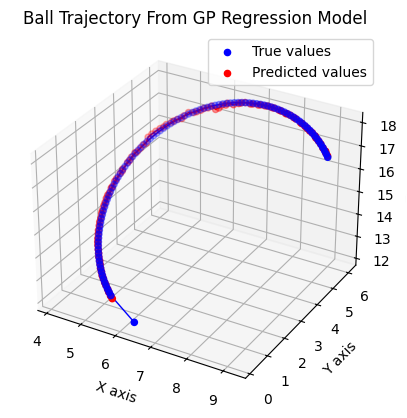

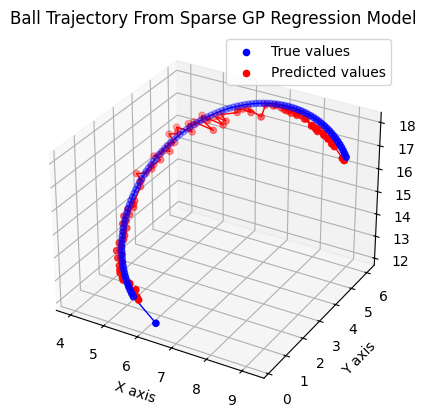

In [150]:
from utils.plot_maker_gaussian_process import plot_maker_3d

plot_maker_3d(y_test, y_pred_reg, "Ball Trajectory From GP Regression Model")
plot_maker_3d(y_test, y_pred_sparse, "Ball Trajectory From Sparse GP Regression Model")